# Setup ENV

In [1]:
# %pip install --upgrade pip
# %pip install pandas numpy
# %pip install scikit-learn scipy
# %pip install odfpy
# %pip install kneed
# %pip install matplotlib seaborn

# Imports

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from kneed import KneeLocator

import matplotlib.pyplot as plt
import seaborn as sns

### Baseline Data: 2022-11 MRT transport data

In [3]:
## baseline data
data_source = "202211_en.ods"
baseline_name = data_source.split(".")[0].split("_")[0]

sample_data = pd.read_excel(f"data/{data_source}", engine="odf", index_col=None)
sample_data.rename(columns={"            StationDate": "StationDate"}, inplace=True)
sample_data.columns

sample_data.index = range(1, sample_data.shape[0]+1)

## create day of week
sample_data["day_of_week"] = sample_data['StationDate'].dt.day_name()
day_of_week_mark = sample_data[["StationDate", "day_of_week"]]

sample_data.head()

,StationDate,Songshan Airport,Zhongshan Junior High School,Nanjing Fuxing,Zhongxiao Fuxing,Daan,Technology Building,Liuzhangli,Linguang,Xinhai,...,Jingping,Zhonghe,Qiaohe,Zhongyuan,Banxin,Banqiao(Circular Line),Xingpu Minsheng,Xingfu,New Taipei Industrial Park,day_of_week
1,2022-11-01,3614,13390,40071,35788,24151,13755,10520,3716,3094,...,4233,4729,2488,3736,3165,7348,2471,3922,5282,Tuesday
2,2022-11-02,3572,13384,40111,36458,23851,13528,10602,3754,3008,...,4021,4610,2434,3591,3044,7335,2401,3872,4984,Wednesday
3,2022-11-03,3733,13150,39857,37400,23797,13512,10433,3605,3113,...,3945,4638,2459,3611,2952,7755,2364,3841,4968,Thursday
4,2022-11-04,4349,14062,42148,44432,25270,13868,11118,3901,3162,...,4216,4819,2569,3607,3096,10184,2539,4268,5285,Friday
5,2022-11-05,2770,8362,22229,41220,14931,10190,7567,3292,2223,...,2867,4207,1221,1319,1946,8153,1876,3235,3376,Saturday


<AxesSubplot: xlabel='StationDate'>

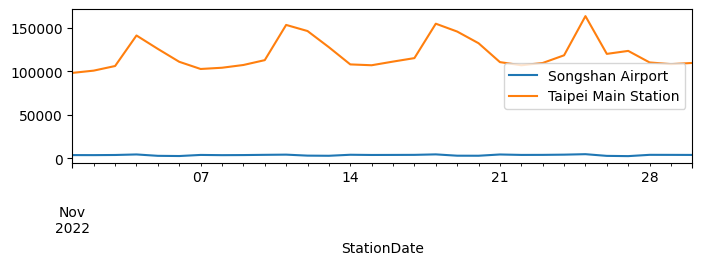

In [4]:
sample_data.plot(x="StationDate", y=["Songshan Airport ", "Taipei Main Station"], kind="line", figsize=(8, 2))

### Normalizing

In [5]:
day_data = sample_data.drop(columns=["StationDate", "day_of_week"])

scaler = MinMaxScaler()
scaler.fit(day_data)

scaled_day_data = scaler.fit_transform(day_data)
scaled_day_data = pd.DataFrame(scaled_day_data, columns=day_data.columns)
scaled_day_data = scaled_day_data.transpose()


day_data = day_data.transpose()
scaled_day_data.columns = day_data.columns

scaled_day_data.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Songshan Airport,0.533543,0.514633,0.587123,0.864475,0.153534,0.045925,0.615489,0.498424,0.546150,0.667267,...,0.846015,0.622692,0.646105,0.760468,1.000000,0.129221,0.000000,0.665016,0.646556,0.612337
Zhongshan Junior High School,0.866658,0.865906,0.836553,0.950953,0.235951,0.003011,0.777847,0.871425,0.876317,0.878324,...,0.817737,0.854240,0.930758,0.943552,1.000000,0.182639,0.000000,0.775088,0.858254,0.905294
Nanjing Fuxing,0.817270,0.818644,0.809920,0.888610,0.204438,0.000000,0.737412,0.819159,0.825410,0.828467,...,0.765336,0.833929,0.882702,0.921962,1.000000,0.186062,0.035275,0.764306,0.830013,0.863983
Zhongxiao Fuxing,0.211562,0.234133,0.265867,0.502762,0.394556,0.071756,0.193269,0.242690,0.315052,0.935959,...,0.663489,0.241881,0.256502,0.307910,0.528938,0.268158,0.000000,0.175785,0.225408,0.292717
Daan,0.849878,0.830590,0.827118,0.921821,0.257104,0.000000,0.788415,0.841070,0.873666,0.866465,...,0.803845,0.840298,0.914106,0.932107,1.000000,0.236852,0.051948,0.804616,0.866658,0.887875


<AxesSubplot: >

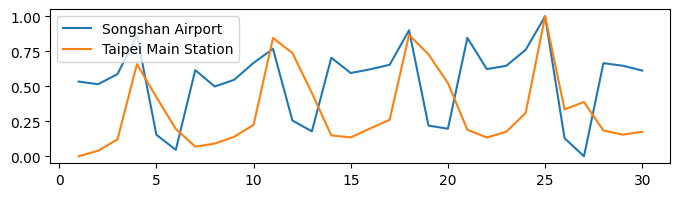

In [6]:
scaled_day_data.transpose().plot(y=["Songshan Airport ", "Taipei Main Station"], kind="line", figsize=(8, 2))

## Perform PCA

In [7]:
pca = PCA(n_components=10)
pca.fit(scaled_day_data)

PCA(n_components=10)

In [8]:
explained_ration = pca.explained_variance_ratio_
print(explained_ration)

[0.82230194 0.04449239 0.03149917 0.02068909 0.01520223 0.01187641
 0.00986543 0.0080769  0.00571132 0.00460434]


### principle components

In [9]:
transformed_data = pca.fit_transform(scaled_day_data)
transformed_data = pd.DataFrame(transformed_data, index=scaled_day_data.index)

## K-Means Cluster

### Elbow detection

4


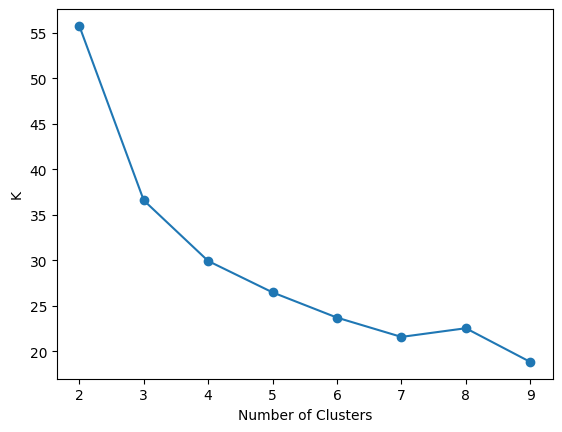

In [10]:
def find_k(df, upperbound=transformed_data.shape[1]):
    ks = []
    for k in range(2, upperbound):
        model = KMeans(n_clusters=k, random_state=7, n_init="auto").fit(df)
        ks.append(model.inertia_)

    ## Plotting the inertia of the models    
    k_values = range(2, upperbound)
    plt.plot(k_values, ks, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("K")

    ## Using elbow methods
    kn = KneeLocator(k_values, ks, curve="convex", direction="decreasing")
    return kn.knee

k = find_k(transformed_data)
print(k)

### K-Means with $k=4$

In [11]:
def k_means_df(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=7, n_init="auto")
    kmeans.fit(df)
    df["cluster"] = kmeans.labels_
    return df

km_day = k_means_df(transformed_data, k)
km_day.head()

,0,1,2,3,4,5,6,7,8,9,cluster
Songshan Airport,0.127937,-0.341269,-0.309304,-0.104910,0.254604,-0.075310,0.024830,0.102412,0.118206,-0.178606,2
Zhongshan Junior High School,-0.801220,-0.007141,-0.044908,0.003571,0.058588,0.025537,-0.025328,-0.006567,-0.020907,0.027573,1
Nanjing Fuxing,-0.651851,-0.112587,-0.151482,0.031016,0.009602,0.015461,-0.025722,0.003897,0.005438,0.020538,1
Zhongxiao Fuxing,1.547175,0.118611,0.371343,-0.369430,0.468760,-0.504285,-0.293433,0.052483,0.105232,-0.002544,0
Daan,-0.735695,0.035639,-0.009175,-0.005111,-0.028621,0.018727,-0.043322,0.009224,-0.010837,0.000252,1


In [12]:
## Group counts
byday_cluster = km_day[["cluster"]]
byday_cluster.reset_index(inplace=True)
byday_cluster.columns = ["StationCount", "cluster"]
byday_cluster.groupby("cluster").agg("count")

,StationCount
cluster,
0,13
1,63
2,33
3,10


In [13]:
group0 = km_day.loc[km_day["cluster"] == 0]
group1 = km_day.loc[km_day["cluster"] == 1]
group2 = km_day.loc[km_day["cluster"] == 2]
group3 = km_day.loc[km_day["cluster"] == 3]

### Cluster results

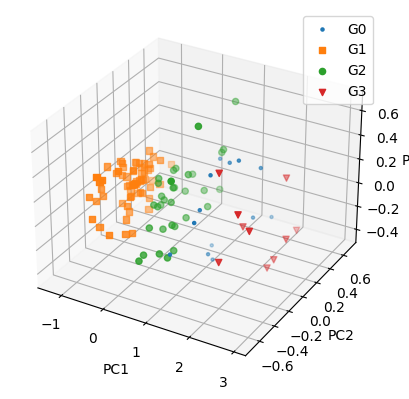

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(group0[0], group0[1], group0[2], marker=".", label="G0")
ax.scatter(group1[0], group1[1], group1[2], marker=",", label="G1")
ax.scatter(group2[0], group2[1], group2[2], marker="o", label="G2")
ax.scatter(group3[0], group3[1], group3[2], marker="v", label="G3")

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend()
plt.show()

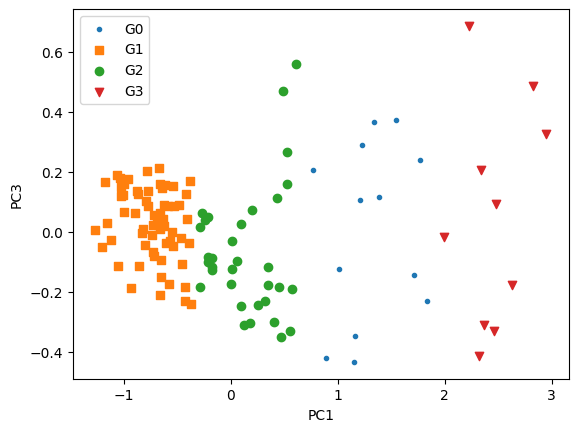

In [15]:
## using only PC1, PC3
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(group0[0], group0[2], marker=".", label="G0")
ax.scatter(group1[0], group1[2], marker=",", label="G1")
ax.scatter(group2[0], group2[2], marker="o", label="G2")
ax.scatter(group3[0], group3[2], marker="v", label="G3")

ax.set_xlabel('PC1')
ax.set_ylabel('PC3')
plt.legend()
plt.show()

### Plot cluster results

In [16]:
group0_ = scaled_day_data.transpose()[group0.index.tolist()]
group1_ = scaled_day_data.transpose()[group1.index.tolist()]
group2_ = scaled_day_data.transpose()[group2.index.tolist()]
group3_ = scaled_day_data.transpose()[group3.index.tolist()]

group0_["mean"] = group0_.mean(axis=1)
group1_["mean"] = group1_.mean(axis=1)
group2_["mean"] = group2_.mean(axis=1)
group3_["mean"] = group3_.mean(axis=1)

In [17]:
def plot_group_lines(df, day_of_week_mark, title=None):
    sunday_mark = day_of_week_mark.index[day_of_week_mark["day_of_week"] == "Sunday"].tolist()

    plt.figure(figsize=(15, 4))
    for col in df.columns:
        if not col == "mean":
            plt.plot(range(1, df.shape[0]+1), df[col], color="#d9d9d9")
        else:
            plt.plot(range(1, df.shape[0]+1), df[col], color="blue", label="Group Mean")

    #plot week boundary
    for marker in sunday_mark:
        plt.axvline(x = marker, color="k", linestyle="--", linewidth=1)

    #plot start and end boundary
    plt.axvline(x = 1, color="gray", linestyle="--",linewidth=1)
    plt.axvline(x = df.shape[0], color="gray", linestyle="--", linewidth=1)

    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

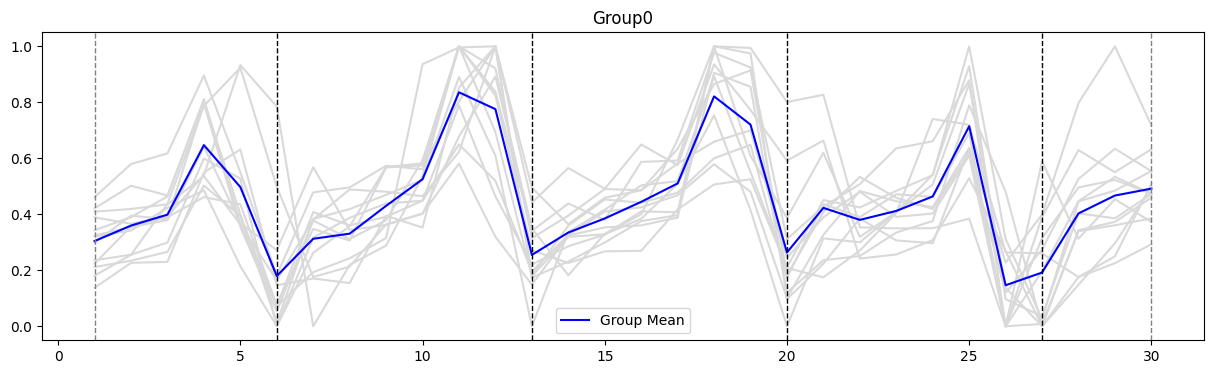

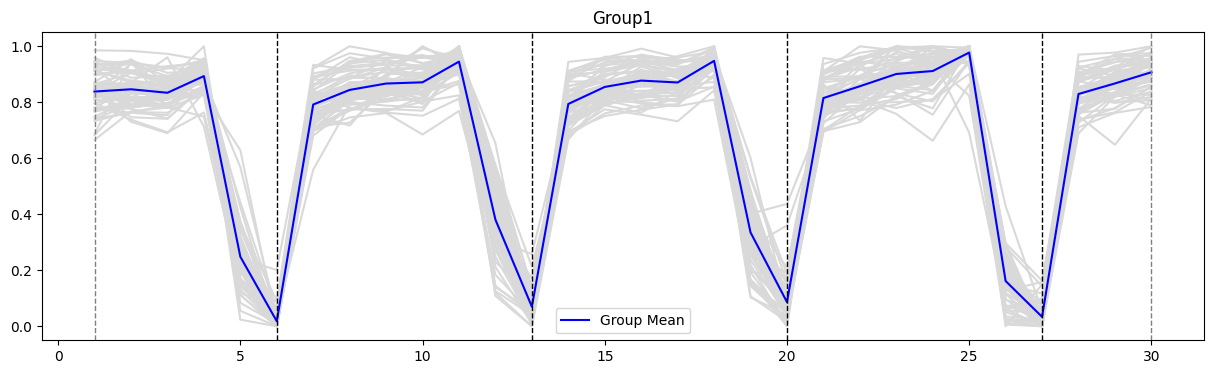

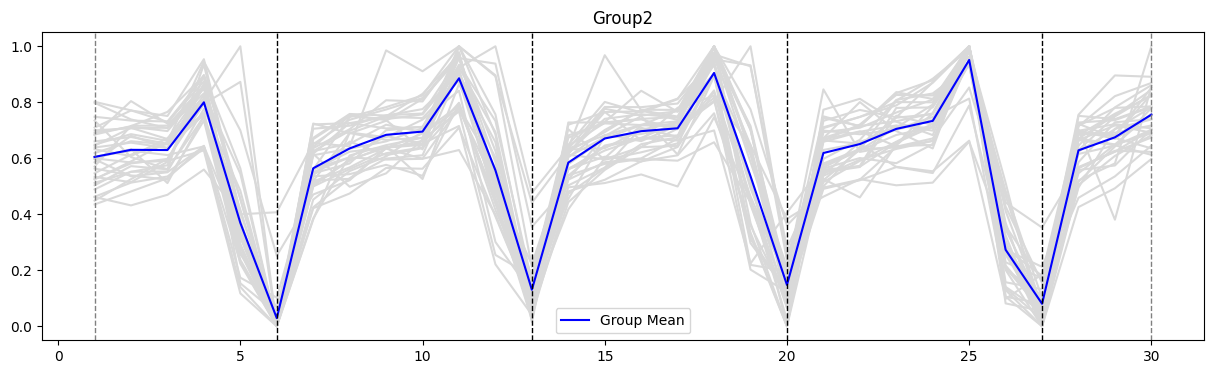

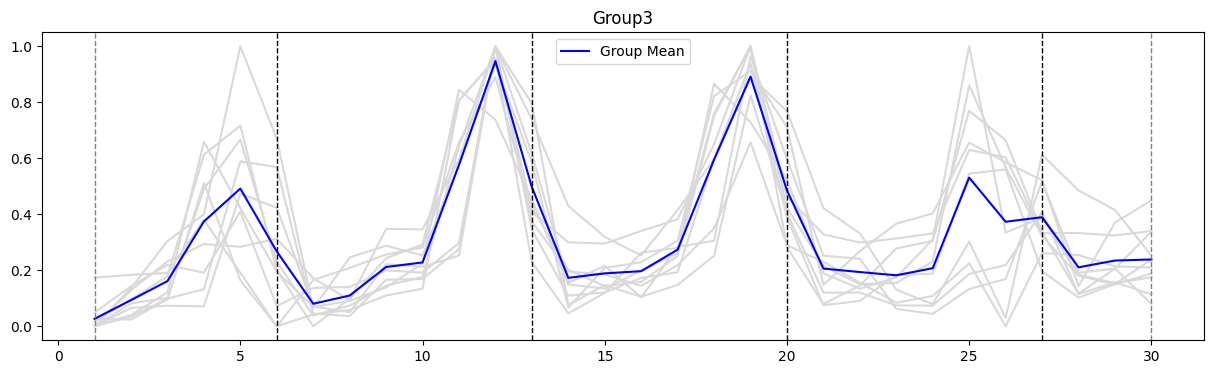

In [18]:
plot_group_lines(group0_, day_of_week_mark, "Group0")
plot_group_lines(group1_, day_of_week_mark, "Group1")
plot_group_lines(group2_, day_of_week_mark, "Group2")
plot_group_lines(group3_, day_of_week_mark, "Group3")

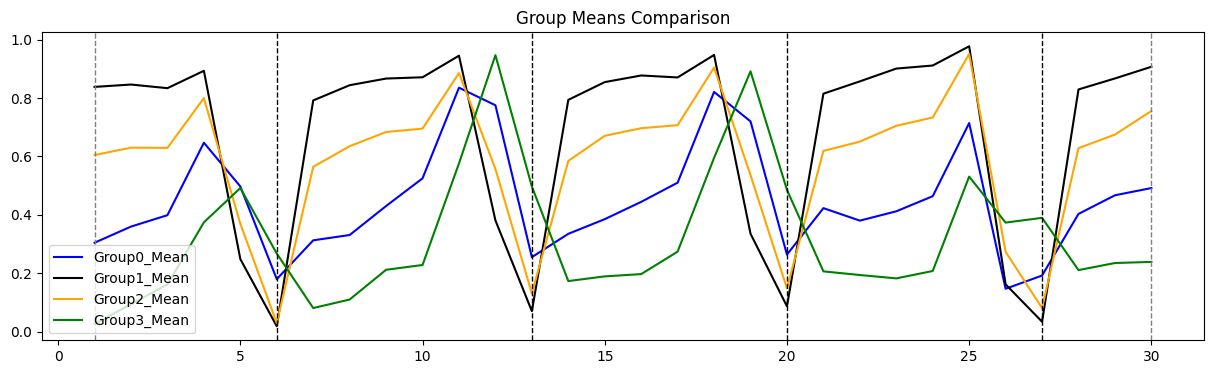

In [19]:
## group mean compare
groups_means = pd.concat([group0_[["mean"]], group1_[["mean"]], group2_[["mean"]], group3_[["mean"]]], axis=1)
groups_means.columns = ["Group0_Mean", "Group1_Mean", "Group2_Mean", "Group3_Mean"]


plt.figure(figsize=(15, 4))
plt.plot(range(1, groups_means.shape[0]+1), groups_means["Group0_Mean"], label="Group0_Mean", color="blue")
plt.plot(range(1, groups_means.shape[0]+1), groups_means["Group1_Mean"], label="Group1_Mean", color="k")
plt.plot(range(1, groups_means.shape[0]+1), groups_means["Group2_Mean"], label="Group2_Mean", color="orange")
plt.plot(range(1, groups_means.shape[0]+1), groups_means["Group3_Mean"], label="Group3_Mean", color="g")

## plot week boundary
sunday_mark = day_of_week_mark.index[day_of_week_mark['day_of_week'] == "Sunday"].tolist()
for marker in sunday_mark:
    plt.axvline(x = marker, color="k", linestyle='--', linewidth=1)

##plot start and end boundary
plt.axvline(x = 1, color="gray", linestyle='--',linewidth=1)
plt.axvline(x = groups_means.shape[0], color="gray", linestyle='--', linewidth=1)

plt.title("Group Means Comparison")
plt.legend()
plt.show()

In [20]:
## save group info
pd.DataFrame(group0_.columns, columns=["StationName"]).to_csv("results/group0_StationName.csv")
pd.DataFrame(group1_.columns, columns=["StationName"]).to_csv("results/group1_StationName.csv")
pd.DataFrame(group2_.columns, columns=["StationName"]).to_csv("results/group2_StationName.csv")
pd.DataFrame(group3_.columns, columns=["StationName"]).to_csv("results/group3_StationName.csv")
